# 1. Setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'Telugu'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'

In [3]:
character_df_fp = f'Data/Characters/Characters-{language}.csv'

In [4]:
cpu_count = 8
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

8
cuda


# 2. Define character class

In [5]:
character_df = pd.read_csv(character_df_fp)
print(character_df.shape)
character_df.head()

(554, 3)


,Character,Consonant,Glyph
0,అ,-,-
1,ఆ,-,ా
2,ఇ,-,ి
3,ఈ,-,ీ
4,ఉ,-,ు


In [6]:
#character_df[character_df['Consonant']=="-"]

In [7]:
characters = set()
for character in character_df['Character'].values:
    characters.update(list(character))
characters = ["-"] + sorted(list(characters))
print(len(characters))
print(characters)

65
['-', 'అ', 'ఆ', 'ఇ', 'ఈ', 'ఉ', 'ఊ', 'ఋ', 'ఌ', 'ఎ', 'ఏ', 'ఐ', 'ఒ', 'ఓ', 'ఔ', 'క', 'ఖ', 'గ', 'ఘ', 'ఙ', 'చ', 'ఛ', 'జ', 'ఝ', 'ఞ', 'ట', 'ఠ', 'డ', 'ఢ', 'ణ', 'త', 'థ', 'ద', 'ధ', 'న', 'ప', 'ఫ', 'బ', 'భ', 'మ', 'య', 'ర', 'ఱ', 'ల', 'ళ', 'ఴ', 'వ', 'శ', 'ష', 'స', 'హ', 'ా', 'ి', 'ీ', 'ు', 'ూ', 'ృ', 'ె', 'ే', 'ై', 'ొ', 'ో', 'ౌ', '్', 'ౢ']


In [8]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'అ', 2: 'ఆ', 3: 'ఇ', 4: 'ఈ', 5: 'ఉ', 6: 'ఊ', 7: 'ఋ', 8: 'ఌ', 9: 'ఎ', 10: 'ఏ', 11: 'ఐ', 12: 'ఒ', 13: 'ఓ', 14: 'ఔ', 15: 'క', 16: 'ఖ', 17: 'గ', 18: 'ఘ', 19: 'ఙ', 20: 'చ', 21: 'ఛ', 22: 'జ', 23: 'ఝ', 24: 'ఞ', 25: 'ట', 26: 'ఠ', 27: 'డ', 28: 'ఢ', 29: 'ణ', 30: 'త', 31: 'థ', 32: 'ద', 33: 'ధ', 34: 'న', 35: 'ప', 36: 'ఫ', 37: 'బ', 38: 'భ', 39: 'మ', 40: 'య', 41: 'ర', 42: 'ఱ', 43: 'ల', 44: 'ళ', 45: 'ఴ', 46: 'వ', 47: 'శ', 48: 'ష', 49: 'స', 50: 'హ', 51: 'ా', 52: 'ి', 53: 'ీ', 54: 'ు', 55: 'ూ', 56: 'ృ', 57: 'ె', 58: 'ే', 59: 'ై', 60: 'ొ', 61: 'ో', 62: 'ౌ', 63: '్', 64: 'ౢ'}
{'-': 0, 'అ': 1, 'ఆ': 2, 'ఇ': 3, 'ఈ': 4, 'ఉ': 5, 'ఊ': 6, 'ఋ': 7, 'ఌ': 8, 'ఎ': 9, 'ఏ': 10, 'ఐ': 11, 'ఒ': 12, 'ఓ': 13, 'ఔ': 14, 'క': 15, 'ఖ': 16, 'గ': 17, 'ఘ': 18, 'ఙ': 19, 'చ': 20, 'ఛ': 21, 'జ': 22, 'ఝ': 23, 'ఞ': 24, 'ట': 25, 'ఠ': 26, 'డ': 27, 'ఢ': 28, 'ణ': 29, 'త': 30, 'థ': 31, 'ద': 32, 'ధ': 33, 'న': 34, 'ప': 35, 'ఫ': 36, 'బ': 37, 'భ': 38, 'మ': 39, 'య': 40, 'ర': 41, 'ఱ': 42, 'ల': 43, 'ళ': 44, 'ఴ': 45, 'వ': 46, 'శ': 47, '

# 3. Define data loader

In [9]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [10]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 
testset = IndianSceneTextDataset(test_dir) 
print(len(trainset), len(valset), len(testset))

train_loader = DataLoader(trainset, batch_size=16, num_workers=1, shuffle=True)
val_loader = DataLoader(valset, batch_size=16, num_workers=1, shuffle=False)
test_loader = DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)
print(len(train_loader), len(val_loader), len(test_loader))

400000 5000 5000
25000 313 313


In [11]:
image_batch, text_batch, image_fn_batch = iter(train_loader).next()
print(image_batch.size())
print(text_batch)

torch.Size([16, 3, 50, 200])
('అని', 'గల', 'ఇక్కడ', 'వరి', 'బాలబడి', 'ఒక', 'వరి', 'ఒకటి', 'పట్ల', 'కోన', 'ఇది', 'వరి', 'తన', 'పుట', 'సహకార', 'ఒక')


In [12]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

In [13]:
for text in text_batch:
    print(text, tokenize(text))

అని ['అ', 'న', 'ి']
గల ['గ', 'ల']
ఇక్కడ ['ఇ', 'క', '్', 'క', 'డ']
వరి ['వ', 'ర', 'ి']
బాలబడి ['బ', 'ా', 'ల', 'బ', 'డ', 'ి']
ఒక ['ఒ', 'క']
వరి ['వ', 'ర', 'ి']
ఒకటి ['ఒ', 'క', 'ట', 'ి']
పట్ల ['ప', 'ట', '్', 'ల']
కోన ['క', 'ో', 'న']
ఇది ['ఇ', 'ద', 'ి']
వరి ['వ', 'ర', 'ి']
తన ['త', 'న']
పుట ['ప', 'ు', 'ట']
సహకార ['స', 'హ', 'క', 'ా', 'ర']
ఒక ['ఒ', 'క']


# 4. Define model

In [14]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [15]:
for p in resnet.parameters():
    pass#p.requires_grad = False

In [16]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

In [17]:
def weights_init(m):
    classname = m.__class__.__name__
    if type(m) in [nn.Linear, nn.Conv2d, nn.Conv1d]:
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [18]:
crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=256)
#crnn.apply(weights_init)
crnn = crnn.to(device)

In [19]:
#crnn

In [20]:
text_batch_logits = crnn(image_batch.to(device))
print(text_batch)
print(text_batch_logits.shape)

('అని', 'గల', 'ఇక్కడ', 'వరి', 'బాలబడి', 'ఒక', 'వరి', 'ఒకటి', 'పట్ల', 'కోన', 'ఇది', 'వరి', 'తన', 'పుట', 'సహకార', 'ఒక')
torch.Size([13, 16, 65])


In [21]:
#text_batch_logits.log_softmax(2)

# 5. Define loss

In [22]:
criterion = nn.CTCLoss(blank=0)

In [23]:
def encode_text_batch(text_batch):
    
    text_batch = [tokenize(text) for text in text_batch]
    text_batch_targets_lens = [len(text) for text in text_batch]
    text_batch_targets_lens = torch.IntTensor(text_batch_targets_lens)
    
    text_batch_concat = []
    for text in text_batch:
        for token in text:
            text_batch_concat.append(token)
 
    text_batch_targets = [char2idx[c] for c in text_batch_concat]
    text_batch_targets = torch.IntTensor(text_batch_targets)
    
    return text_batch_targets, text_batch_targets_lens

In [24]:
def compute_loss(text_batch, text_batch_logits):
    """
    text_batch: list of strings of length equal to batch size
    text_batch_logits: Tensor of size([T, batch_size, num_classes])
    """
    text_batch_logps = F.log_softmax(text_batch_logits, 2) # [T, batch_size, num_classes]  
    text_batch_logps_lens = torch.full(size=(text_batch_logps.size(1),), 
                                       fill_value=text_batch_logps.size(0), 
                                       dtype=torch.int32).to(device) # [batch_size] 
    #print(text_batch_logps.shape)
    #print(text_batch_logps_lens) 
    text_batch_targets, text_batch_targets_lens = encode_text_batch(text_batch)
    #print(text_batch_targets)
    #print(text_batch_targets_lens)
    loss = criterion(text_batch_logps, text_batch_targets, text_batch_logps_lens, text_batch_targets_lens)

    return loss

In [25]:
compute_loss(text_batch, text_batch_logits)

tensor(15.6202, device='cuda:0', grad_fn=<MeanBackward0>)

# 6. Train model

In [26]:
# Hyperparameters: Data Loading
batch_size = 64

# Hyperparameters: Model Architecture
rnn_hidden_size = 256

# Hyperparameters: Training
num_epochs = 40
lr = 0.001
weight_decay = 1e-5
clip_norm = 5
step_size = 5
gamma = 0.90

In [27]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir) 

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=True)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

crnn = CRNN(num_chars=len(char2idx), rnn_hidden_size=rnn_hidden_size)
#crnn.apply(weights_init)
crnn = crnn.to(device)

optimizer = optim.Adam(crnn.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

In [28]:
epoch_losses = []
epoch_losses_val = []
iteration_losses = []
num_updates_epochs = []
for epoch in tqdm(range(1, num_epochs+1)):
    epoch_loss_list = [] 
    epoch_loss_list_val = []
    num_updates_epoch = 0

    crnn.train()
    for image_batch, text_batch, image_fn_batch in tqdm(train_loader, leave=False, desc="Train"):
        optimizer.zero_grad()
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
          
        num_updates_epoch += 1
        iteration_losses.append(iteration_loss)
        epoch_loss_list.append(iteration_loss)
        loss.backward()
        nn.utils.clip_grad_norm_(crnn.parameters(), clip_norm)
        optimizer.step()

    crnn.eval()
    for image_batch, text_batch, image_fn_batch in tqdm(val_loader, leave=False, desc="Val"):
        text_batch_logits = crnn(image_batch.to(device))
        loss = compute_loss(text_batch, text_batch_logits)
        iteration_loss = loss.item()
        if np.isnan(iteration_loss) or np.isinf(iteration_loss):
            continue
        epoch_loss_list_val.append(iteration_loss)


    epoch_loss = np.mean(epoch_loss_list)
    epoch_loss_val = np.mean(epoch_loss_list_val)
    print("Epoch:{}    TrainLoss:{}    ValLoss:{}    NumUpdates:{}    LR:{}".\
          format(epoch, epoch_loss, epoch_loss_val, num_updates_epoch, optimizer.param_groups[0]['lr']))
    epoch_losses.append(epoch_loss)
    epoch_losses_val.append(epoch_loss_val)
    num_updates_epochs.append(num_updates_epoch)
    lr_scheduler.step()
    
    if epoch % 10 == 0:
        model_path = f'Models/{language}-Unicode-e{epoch}.pth'
        torch.save(crnn.state_dict(), model_path)

Epoch:1    TrainLoss:1.5419442076301575    ValLoss:0.8428194832198227    NumUpdates:6250    LR:0.001


Epoch:2    TrainLoss:0.8719379800271988    ValLoss:0.7017991039194639    NumUpdates:6250    LR:0.001


Epoch:3    TrainLoss:0.7418735628819466    ValLoss:0.6037063185549989    NumUpdates:6250    LR:0.001


Epoch:4    TrainLoss:0.6763158151841163    ValLoss:0.5702474206874643    NumUpdates:6250    LR:0.001


Epoch:5    TrainLoss:0.6250130245351792    ValLoss:0.5481408463814591    NumUpdates:6250    LR:0.001


Epoch:6    TrainLoss:0.5747665393424034    ValLoss:0.5021922230909143    NumUpdates:6250    LR:0.0009000000000000001


Epoch:7    TrainLoss:0.5475295573139191    ValLoss:0.5165182096482832    NumUpdates:6250    LR:0.0009000000000000001


Epoch:8    TrainLoss:0.5283679229187965    ValLoss:0.4753718811877166    NumUpdates:6250    LR:0.0009000000000000001


Epoch:9    TrainLoss:0.5121759889280796    ValLoss:0.4755493232721015    NumUpdates:6250    LR:0.0009000000000000001


Epoch:10    TrainLoss:0.4989394318675995    ValLoss:0.46584219537392446    NumUpdates:6250    LR:0.0009000000000000001


Epoch:11    TrainLoss:0.46917668062329293    ValLoss:0.44868156422354    NumUpdates:6250    LR:0.0008100000000000001


Epoch:12    TrainLoss:0.4560582189404964    ValLoss:0.454261873766214    NumUpdates:6250    LR:0.0008100000000000001


Epoch:13    TrainLoss:0.4439319086003303    ValLoss:0.44655770070473605    NumUpdates:6250    LR:0.0008100000000000001


Epoch:14    TrainLoss:0.43646011917948724    ValLoss:0.4349944755623612    NumUpdates:6250    LR:0.0008100000000000001


Epoch:15    TrainLoss:0.4267216001689434    ValLoss:0.4428337512455315    NumUpdates:6250    LR:0.0008100000000000001


Epoch:16    TrainLoss:0.40419343974411487    ValLoss:0.4331290025877047    NumUpdates:6250    LR:0.000729


Epoch:17    TrainLoss:0.3945814611566067    ValLoss:0.4211277646731727    NumUpdates:6250    LR:0.000729


Epoch:18    TrainLoss:0.386073955488801    ValLoss:0.42813549858011024    NumUpdates:6250    LR:0.000729


Epoch:19    TrainLoss:0.3815149037843943    ValLoss:0.4167031552406806    NumUpdates:6250    LR:0.000729


Epoch:20    TrainLoss:0.3755652274143696    ValLoss:0.43420267185267014    NumUpdates:6250    LR:0.000729


Epoch:21    TrainLoss:0.3550095294809341    ValLoss:0.4113848232634696    NumUpdates:6250    LR:0.0006561000000000001


Epoch:22    TrainLoss:0.3470949534505606    ValLoss:0.41192186062660396    NumUpdates:6250    LR:0.0006561000000000001


Epoch:23    TrainLoss:0.34174964925825596    ValLoss:0.42595792809336247    NumUpdates:6250    LR:0.0006561000000000001


Epoch:24    TrainLoss:0.33696574458658696    ValLoss:0.41568690958090976    NumUpdates:6250    LR:0.0006561000000000001


Epoch:25    TrainLoss:0.33305000491559505    ValLoss:0.4171450231401132    NumUpdates:6250    LR:0.0006561000000000001


Epoch:26    TrainLoss:0.3161767905154824    ValLoss:0.41946526739416246    NumUpdates:6250    LR:0.00059049


Epoch:27    TrainLoss:0.3087762356135249    ValLoss:0.4196557374376379    NumUpdates:6250    LR:0.00059049


Epoch:28    TrainLoss:0.3056537370476127    ValLoss:0.40316147669189006    NumUpdates:6250    LR:0.00059049


Epoch:29    TrainLoss:0.30172494482755663    ValLoss:0.4000065505410297    NumUpdates:6250    LR:0.00059049


Epoch:30    TrainLoss:0.2977733169195056    ValLoss:0.42747415358177093    NumUpdates:6250    LR:0.00059049


Epoch:31    TrainLoss:0.28244565875440836    ValLoss:0.40615974386853365    NumUpdates:6250    LR:0.000531441


Epoch:32    TrainLoss:0.2744249433282018    ValLoss:0.42228487839545065    NumUpdates:6250    LR:0.000531441


Epoch:33    TrainLoss:0.27295135314494373    ValLoss:0.41405259640563186    NumUpdates:6250    LR:0.000531441


Epoch:34    TrainLoss:0.26801381587535145    ValLoss:0.42691520307617575    NumUpdates:6250    LR:0.000531441


Epoch:35    TrainLoss:0.2655737406795472    ValLoss:0.43350583423942896    NumUpdates:6250    LR:0.000531441


Epoch:36    TrainLoss:0.251130980765149    ValLoss:0.4274807259664411    NumUpdates:6250    LR:0.0004782969


Epoch:37    TrainLoss:0.2455525788190961    ValLoss:0.41284214522206236    NumUpdates:6250    LR:0.0004782969


Epoch:38    TrainLoss:0.24180066227674485    ValLoss:0.4472360797631672    NumUpdates:6250    LR:0.0004782969


Epoch:39    TrainLoss:0.2395681812736392    ValLoss:0.4346773824359797    NumUpdates:6250    LR:0.0004782969


Epoch:40    TrainLoss:0.23763436089560389    ValLoss:0.42709818022632146    NumUpdates:6250    LR:0.0004782969



In [29]:
model_path = f'Models/{language}-Unicode.pth'
torch.save(crnn.state_dict(), model_path)

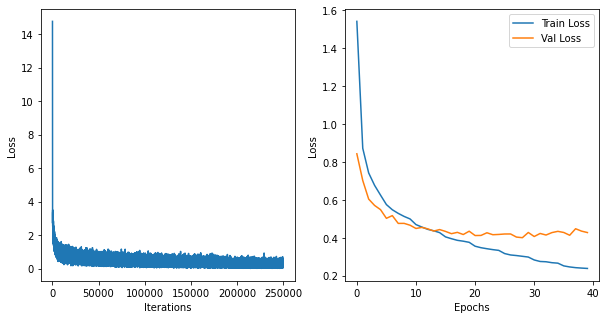

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.plot(iteration_losses)
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")

ax2.plot(epoch_losses, label="Train Loss")
ax2.plot(epoch_losses_val, label="Val Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")

plt.legend()
plt.show()

# 7. Make predictions

In [31]:
#trainset = IndianSceneTextDataset(train_dir) 
#valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir) 

#train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
#val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

In [32]:
model_path = f'Models/{language}-Unicode.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)

In [33]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [34]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [35]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)

In [36]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
train_result.head()

(400000, 3)
(5000, 3)
(5000, 3)


,image_fn,actual,prediction
0,ఉడుత_1_341_1.jpg,ఉడుత,ఉ------డు--త-
1,వనరుల_6_4429_6.jpg,వనరుల,వ---న---రు-ల-
2,వరి_8_4010_1.jpg,వరి,వ----------రి
3,గడబ_9_3777_0.jpg,గడబ,గ------డ---బ-
4,గద_16_1219_0.jpg,గద,గ----------ద-


In [37]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [38]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)

In [39]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)

In [40]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [41]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)

# 8. Evaluate the model

In [42]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy)

0.880325 0.8232 0.8132


In [43]:
for max_edit_distance in range(3+1):
    print("Max Edit Distance", max_edit_distance)
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    print(train_accuracy, val_accuracy, test_accuracy)
    print("*"*50)

Max Edit Distance 0
0.880325 0.8232 0.8132
**************************************************
Max Edit Distance 1
0.9261975 0.8738 0.8716
**************************************************
Max Edit Distance 2
0.9520225 0.9174 0.9124
**************************************************
Max Edit Distance 3
0.969995 0.961 0.9526
**************************************************


In [44]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=2):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

('Actual:', 'వల్లభి', 'Prediction:', 'ప----------వ-', 'Prediction Corrected:', 'పవ')


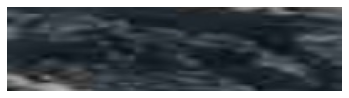

('Actual:', 'వరి', 'Prediction:', 'వ----------ల-', 'Prediction Corrected:', 'వల')


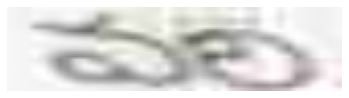

('Actual:', 'ఒక', 'Prediction:', 'వ----------రి', 'Prediction Corrected:', 'వరి')


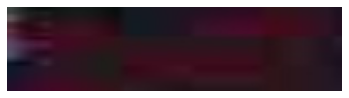

('Actual:', 'కల్లనీ', 'Prediction:', 'క-----ల----వ-', 'Prediction Corrected:', 'కలవ')


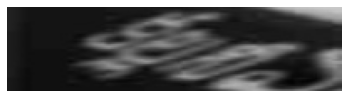

('Actual:', 'పతివ్రత', 'Prediction:', 'ప-----ి-ర--త-', 'Prediction Corrected:', 'పిరత')


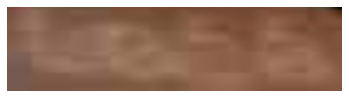

('Actual:', 'ఇవివిసత్యనారా', 'Prediction:', '--ాాౌఇ---ఋఉఐ-', 'Prediction Corrected:', 'ాౌఇఋఉఐ')


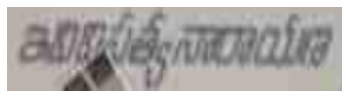

('Actual:', 'వ్యవస్థ', 'Prediction:', 'వ------------', 'Prediction Corrected:', 'వ')


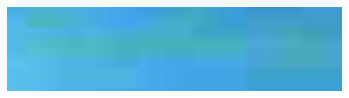

('Actual:', 'అరికతోట', 'Prediction:', 'అ--రిక్కకో-ట-', 'Prediction Corrected:', 'అరిక్కోట')


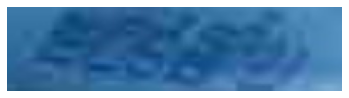

('Actual:', 'ఆటో', 'Prediction:', 'ఉ----------ర-', 'Prediction Corrected:', 'ఉర')


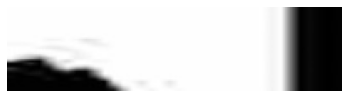

('Actual:', 'తన', 'Prediction:', 'ఉ----------ప-', 'Prediction Corrected:', 'ఉప')


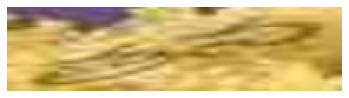

('Actual:', 'మరదవాడ', 'Prediction:', 'మ---మ-ర-ూ--డి', 'Prediction Corrected:', 'మమరూడి')


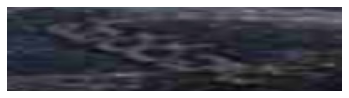

('Actual:', 'పగ', 'Prediction:', 'ఆ----------ర-', 'Prediction Corrected:', 'ఆర')


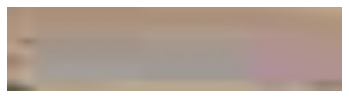

('Actual:', 'పైబడిన', 'Prediction:', 'ఒ----------ర-', 'Prediction Corrected:', 'ఒర')


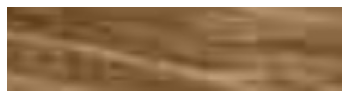

('Actual:', 'జనన', 'Prediction:', 'త----------న-', 'Prediction Corrected:', 'తన')


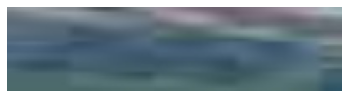

('Actual:', 'అలజడి', 'Prediction:', 'ఆ-----ర----ల-', 'Prediction Corrected:', 'ఆరల')


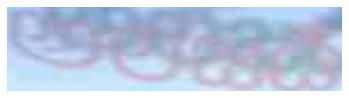

('Actual:', 'యడబల్లె', 'Prediction:', 'వ--------ల్లి', 'Prediction Corrected:', 'వల్లి')


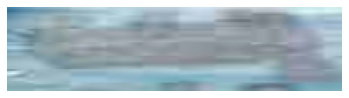

('Actual:', 'సత్యవాడ', 'Prediction:', '-్ృృృాఒఒ-ఒ--ఈ', 'Prediction Corrected:', '్ృాఒఒఈ')


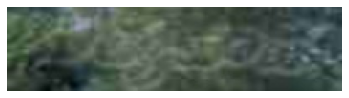

('Actual:', 'శిక్షణ', 'Prediction:', 'వ----------రి', 'Prediction Corrected:', 'వరి')


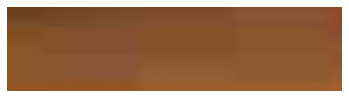

('Actual:', 'ఒక్క', 'Prediction:', 'ఒ----------క-', 'Prediction Corrected:', 'ఒక')


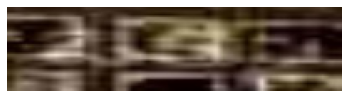

('Actual:', 'శాల', 'Prediction:', 'చౌ---------ర-', 'Prediction Corrected:', 'చౌర')


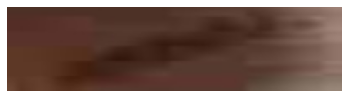

In [45]:
visualize_misclassifications('Train')

('Actual:', 'తల', 'Prediction:', 'క----------థ-', 'Prediction Corrected:', 'కథ')


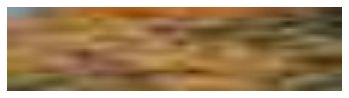

('Actual:', 'ప్రధాన', 'Prediction:', 'ఆ----------వ-', 'Prediction Corrected:', 'ఆవ')


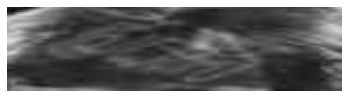

('Actual:', 'శమీ', 'Prediction:', 'త----------మ-', 'Prediction Corrected:', 'తమ')


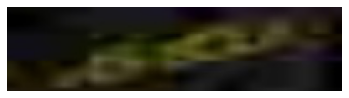

('Actual:', 'పరన్నవలస', 'Prediction:', 'ప-రిమ్్వవవలసస', 'Prediction Corrected:', 'పరిమ్వలస')


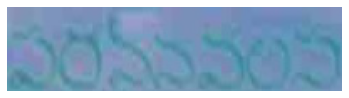

('Actual:', 'వరి', 'Prediction:', 'స----------ర్', 'Prediction Corrected:', 'సర్')


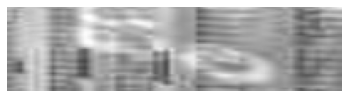

('Actual:', 'యౌవనవతి', 'Prediction:', 'యా---ప-న-వ-లి', 'Prediction Corrected:', 'యాపనవలి')


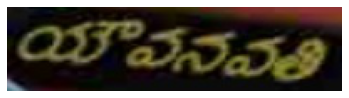

('Actual:', 'ఎగుర', 'Prediction:', 'న------గగ--రి', 'Prediction Corrected:', 'నగరి')


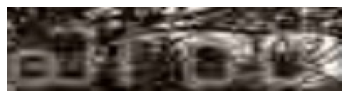

('Actual:', 'రగడ', 'Prediction:', 'వ----------ర-', 'Prediction Corrected:', 'వర')


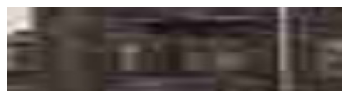

('Actual:', 'తలగడదీవి', 'Prediction:', 'అ--------ర-వ-', 'Prediction Corrected:', 'అరవ')


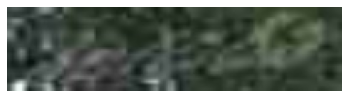

('Actual:', 'ఎస్', 'Prediction:', 'వ----------రి', 'Prediction Corrected:', 'వరి')


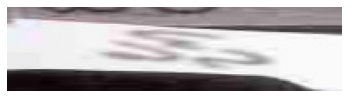

('Actual:', 'కమల్పి', 'Prediction:', 'క--------్-వ-', 'Prediction Corrected:', 'క్వ')


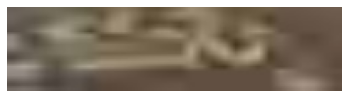

('Actual:', 'ఇవి', 'Prediction:', 'ఉ----------ప-', 'Prediction Corrected:', 'ఉప')


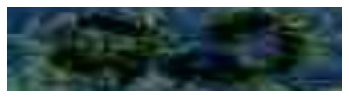

('Actual:', 'ల', 'Prediction:', 'ఉ----------ర-', 'Prediction Corrected:', 'ఉర')


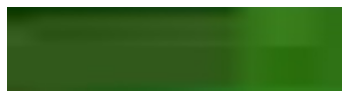

('Actual:', 'ఇలా', 'Prediction:', 'క----------ల-', 'Prediction Corrected:', 'కల')


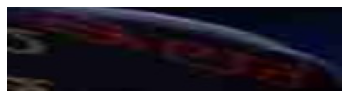

('Actual:', 'పెదఖర్జ', 'Prediction:', 'వ-------ద్్ద-', 'Prediction Corrected:', 'వద్ద')


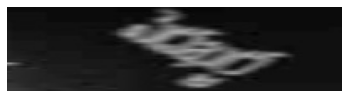

('Actual:', 'భారత', 'Prediction:', 'ప----------న-', 'Prediction Corrected:', 'పన')


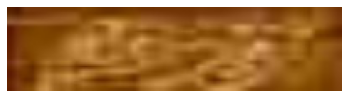

('Actual:', 'నడవవు', 'Prediction:', 'వ----డ--ద--ర-', 'Prediction Corrected:', 'వడదర')


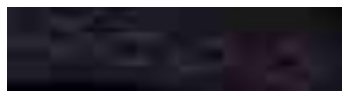

('Actual:', 'వరి', 'Prediction:', 'క----------థ-', 'Prediction Corrected:', 'కథ')


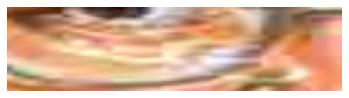

('Actual:', 'సజ్జ', 'Prediction:', 'వ------ష్్-డ-', 'Prediction Corrected:', 'వష్డ')


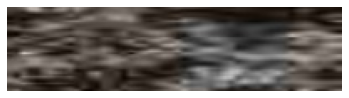

('Actual:', 'వరి', 'Prediction:', 'త----------ప-', 'Prediction Corrected:', 'తప')


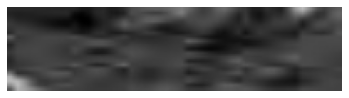

In [46]:
visualize_misclassifications('Val')

('Actual:', 'ఆ', 'Prediction:', 'అ----------వి', 'Prediction Corrected:', 'అవి')


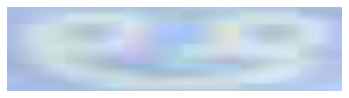

('Actual:', 'ఎత', 'Prediction:', 'ప----------గ-', 'Prediction Corrected:', 'పగ')


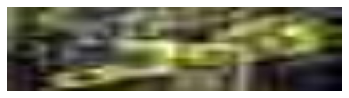

('Actual:', 'వరి', 'Prediction:', 'ప----------ర-', 'Prediction Corrected:', 'పర')


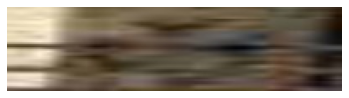

('Actual:', 'ఒకటి', 'Prediction:', 'ఒ----------క-', 'Prediction Corrected:', 'ఒక')


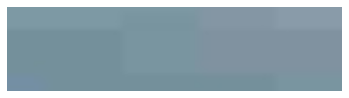

('Actual:', 'సరఫరా', 'Prediction:', 'స-ర్ర--వ---రా', 'Prediction Corrected:', 'సర్రవరా')


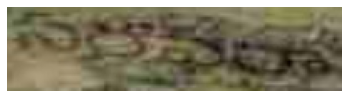

('Actual:', 'ఒకటి', 'Prediction:', 'ఒ----------ర-', 'Prediction Corrected:', 'ఒర')


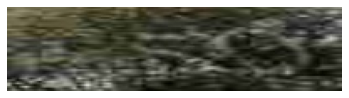

('Actual:', 'అవి', 'Prediction:', 'వ----------రి', 'Prediction Corrected:', 'వరి')


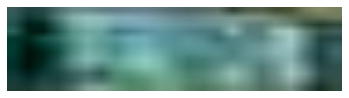

('Actual:', 'పశు', 'Prediction:', 'ప----------సి', 'Prediction Corrected:', 'పసి')


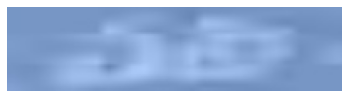

('Actual:', 'ఏట', 'Prediction:', 'వ----------రి', 'Prediction Corrected:', 'వరి')


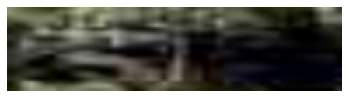

('Actual:', 'సర్', 'Prediction:', 'వ----------రి', 'Prediction Corrected:', 'వరి')


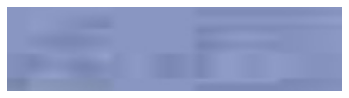

('Actual:', 'ఉదాహరణ', 'Prediction:', 'ఉ-------ృ----', 'Prediction Corrected:', 'ఉృ')


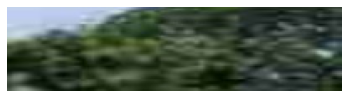

('Actual:', 'చరిత్ర', 'Prediction:', 'చ------రి--త-', 'Prediction Corrected:', 'చరిత')


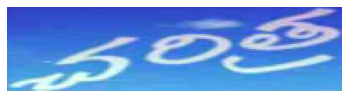

('Actual:', 'ప్లవనశక్తి', 'Prediction:', 'ప్--న-హసకా-థి', 'Prediction Corrected:', 'ప్నహసకాథి')


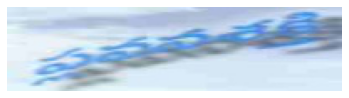

('Actual:', 'అగదల', 'Prediction:', 'మ----ర--ద--ల-', 'Prediction Corrected:', 'మరదల')


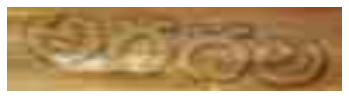

('Actual:', 'అలా', 'Prediction:', 'స----------త-', 'Prediction Corrected:', 'సత')


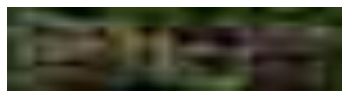

('Actual:', 'ఒకటి', 'Prediction:', 'చ----------వి', 'Prediction Corrected:', 'చవి')


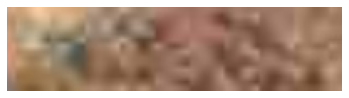

('Actual:', 'కల్వరాల', 'Prediction:', 'క---ల--ర---ర-', 'Prediction Corrected:', 'కలరర')


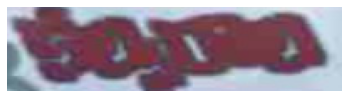

('Actual:', 'లలిత', 'Prediction:', 'ఒక---------ర-', 'Prediction Corrected:', 'ఒకర')


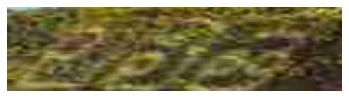

('Actual:', 'గరీబన్', 'Prediction:', 'గ---ర--ల---న్', 'Prediction Corrected:', 'గరలన్')


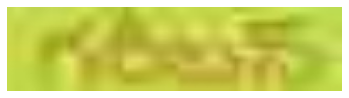

('Actual:', 'అరిముతనపల్లె', 'Prediction:', 'ఆర్ిుుుుి్్ల్', 'Prediction Corrected:', 'ఆర్ిుి్ల్')


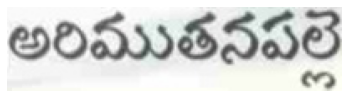

In [47]:
visualize_misclassifications('Test')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

Loss cannot be reduced beyond 0.54 in val set (after 20 epochs)